In [1]:
import numpy as np
import time
from collections import namedtuple
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import qiskit as q
import qiskit.tools.jupyter
from qiskit.pulse import pulse_lib as _  # only want to call pulse_lib as q.pulse.pulse_lib
from qiskit.test.mock import FakeAlmaden
from qiskit.ignis.verification.tomography.data import marginal_counts

In [3]:
import pulse_compiler_helper_fns

In [4]:
backend = FakeAlmaden()
system = q.pulse.PulseChannelSpec.from_backend(backend)
back_config = backend.configuration().to_dict()
cmd_def = q.pulse.CmdDef.from_defaults(backend.defaults().cmd_def, backend.defaults().pulse_library)
measure = cmd_def.get('measure', qubits=backend.configuration().meas_map[0])
backend_sim = qiskit.Aer.get_backend('pulse_simulator')

/Users/pranavgokhale/Developer/qiskit/qiskit-terra/qiskit/pulse/channels/pulse_channel_spec.py:87: DeprecationWarning: The PulseChannelSpec is deprecated. Use backend.configuration() instead. The supported methods require some migrations; check out the release notes for the complete details.
  DeprecationWarning)


In [5]:
hamiltonian = {}
hamiltonian['h_str'] = ['_SUM[i,0,1,wq{i}/2*(I{i}-Z{i})]', '_SUM[i,0,1,omegad{i}*X{i}||D{i}]',
                        'jq0q1*Sp0*Sm1', 'jq0q1*Sm0*Sp1', 'omegad1*X0||U0', 'omegad0*X1||U1']
hamiltonian['qub'] = {'0': 2, '1': 2}
hamiltonian['vars'] = {'wq0': 30.518812656662774, 'wq1': 31.238229295532093,
                       'omegad0': 0.1675, 'omegad1': 0.176,
                       'jq0q1': -0.0069}

back_config['hamiltonian'] = hamiltonian
back_config['noise'] = {}
back_config['dt'] = 1.0
back_config['ode_options'] = {}
back_config['qubit_list'] = [0,1]

In [6]:
# Measure X on target
x_schedules = []
for theta in np.linspace(0, 3*np.pi/4, 32, endpoint=False):
    schedule = pulse_compiler_helper_fns.get_cr_schedule(theta, 0, 1, cmd_def, system) 
    schedule |= cmd_def.get('u2', qubits=[1], P0=0, P1=np.pi) << schedule.duration
    schedule = schedule.filter(channels=[system.qubits[0].drive, system.qubits[1].drive, system.controls[0]])
    schedule |= measure << schedule.duration
    x_schedules.append(schedule)
    
# do same thing, but first flip 
for theta in np.linspace(0, 3*np.pi/4, 32, endpoint=False):
    schedule = cmd_def.get('x', qubits=[0])
    schedule |= pulse_compiler_helper_fns.get_cr_schedule(theta, 0, 1, cmd_def, system) << schedule.duration
    schedule |= cmd_def.get('u2', qubits=[1], P0=0, P1=np.pi) << schedule.duration
    schedule = schedule.filter(channels=[system.qubits[0].drive, system.qubits[1].drive, system.controls[0]])
    schedule |= measure << schedule.duration
    x_schedules.append(schedule)

In [7]:
shots = 1000

In [8]:
qobj = q.assemble(x_schedules, backend, 
                       meas_level=1, meas_return='avg', 
                       memory_slots=2,
                       shots=shots, sim_config = back_config)

In [9]:
evals, estates = backend_sim.get_dressed_energies(qobj)
evals/2/np.pi

array([0.        , 4.85720941, 4.97172909, 9.82893851])

In [10]:
# Measure Y on target
y_schedules = []
for theta in np.linspace(0, 3*np.pi/4, 32, endpoint=False):
    schedule = pulse_compiler_helper_fns.get_cr_schedule(theta, 0, 1, cmd_def, system)
    schedule |= cmd_def.get('u1', qubits=[1], P0=-np.pi/2) << schedule.duration
    schedule |= cmd_def.get('u2', qubits=[1], P0=0, P1=np.pi) << schedule.duration
    schedule = schedule.filter(channels=[system.qubits[0].drive, system.qubits[1].drive, system.controls[0]])
    schedule |= measure << schedule.duration
    y_schedules.append(schedule)
    
# do same thing, but first flip 
for theta in np.linspace(0, 3*np.pi/4, 32, endpoint=False):
    schedule = cmd_def.get('x', qubits=[0])
    schedule |= pulse_compiler_helper_fns.get_cr_schedule(theta, 0, 1, cmd_def, system) << schedule.duration
    schedule |= cmd_def.get('u1', qubits=[1], P0=-np.pi/2) << schedule.duration
    schedule |= cmd_def.get('u2', qubits=[1], P0=0, P1=np.pi) << schedule.duration
    schedule = schedule.filter(channels=[system.qubits[0].drive, system.qubits[1].drive, system.controls[0]])
    schedule |= measure << schedule.duration
    y_schedules.append(schedule)

In [11]:
# Measure Z on target
z_schedules = []
for theta in np.linspace(0, 3*np.pi/4, 32, endpoint=False):
    schedule = pulse_compiler_helper_fns.get_cr_schedule(theta, 0, 1, cmd_def, system)
    schedule = schedule.filter(channels=[system.qubits[0].drive, system.qubits[1].drive, system.controls[0]])
    schedule |= measure << schedule.duration
    z_schedules.append(schedule)
    
# do same thing, but first flip 
for theta in np.linspace(0, 3*np.pi/4, 32, endpoint=False):
    schedule = cmd_def.get('x', qubits=[0])
    schedule |= pulse_compiler_helper_fns.get_cr_schedule(theta, 0, 1, cmd_def, system) << schedule.duration
    schedule = schedule.filter(channels=[system.qubits[0].drive, system.qubits[1].drive, system.controls[0]])
    schedule |= measure << schedule.duration
    z_schedules.append(schedule)

In [13]:
shots = 10000

qobj = q.assemble(x_schedules, backend, 
                     qubit_lo_freq = [evals[1]/2/np.pi, evals[2]/2/np.pi],
                     shots=shots, sim_config = back_config)
x_result = backend_sim.run(qobj).result()

qobj = q.assemble(y_schedules, backend, 
                     qubit_lo_freq = [evals[1]/2/np.pi, evals[2]/2/np.pi],
                     shots=shots, sim_config = back_config)
y_result = backend_sim.run(qobj).result()

qobj = q.assemble(z_schedules, backend, 
                     qubit_lo_freq = [evals[1]/2/np.pi, evals[2]/2/np.pi],
                     shots=shots, sim_config = back_config)
z_result = backend_sim.run(qobj).result()

In [14]:
from qiskit.ignis.verification.tomography.data import marginal_counts

In [15]:
x_vals_control_off = []
for i in range(32):
    x_counts = marginal_counts(x_result.get_counts(i), meas_qubits=[1])
    x_vals_control_off.append((x_counts.get('0', 0) / shots - 0.5) * 2)

x_vals_control_on = []
for i in range(32, 64):
    x_counts = marginal_counts(x_result.get_counts(i), meas_qubits=[1])
    x_vals_control_on.append((x_counts.get('0', 0) / shots - 0.5) * 2)

print(x_vals_control_off)
print(x_vals_control_on)

[0.0023999999999999577, 0.023800000000000043, 0.02719999999999989, 0.06800000000000006, 0.06400000000000006, 0.04800000000000004, 0.06840000000000002, 0.0374000000000001, 0.031199999999999894, -0.0050000000000000044, -0.014399999999999968, -0.03700000000000003, -0.06799999999999995, -0.08040000000000003, -0.133, -0.1502, -0.14239999999999997, -0.125, -0.14139999999999997, -0.11180000000000001, -0.10099999999999998, -0.0948, -0.05179999999999996, -0.047799999999999954, -0.013399999999999967, 0.013400000000000079, 0.02719999999999989, -0.0013999999999999568, 0.036599999999999966, 0.020000000000000018, 0.0018000000000000238, -0.011800000000000033]
[0.0027999999999999137, -0.0242, -0.052200000000000024, -0.0524, -0.08420000000000005, -0.08599999999999997, -0.07940000000000003, -0.10140000000000005, -0.08860000000000001, -0.0928, -0.09540000000000004, -0.06120000000000003, -0.0726, -0.048799999999999955, -0.04300000000000004, -0.0031999999999999806, 0.020199999999999996, 0.03239999999999998

In [16]:
y_vals_control_off = []
for i in range(32):
    y_counts = marginal_counts(y_result.get_counts(i), meas_qubits=[1])
    y_vals_control_off.append((y_counts.get('0', 0) / shots - 0.5) * 2)

y_vals_control_on = []
for i in range(32, 64):
    y_counts = marginal_counts(y_result.get_counts(i), meas_qubits=[1])
    y_vals_control_on.append((y_counts.get('0', 0) / shots - 0.5) * 2)

print(y_vals_control_off)
print(y_vals_control_on)

[0.0029999999999998916, -0.08579999999999999, -0.15639999999999998, -0.22660000000000002, -0.29400000000000004, -0.365, -0.43700000000000006, -0.5092, -0.5794, -0.6268, -0.6894, -0.741, -0.7796, -0.817, -0.8522000000000001, -0.8894, -0.9206, -0.9436, -0.961, -0.978, -0.9892, -0.996, -0.998, -0.9922, -0.9862, -0.9736, -0.9496, -0.9268, -0.9112, -0.871, -0.8524, -0.8062]
[-0.007000000000000006, 0.07539999999999991, 0.17520000000000002, 0.2467999999999999, 0.2994000000000001, 0.38480000000000003, 0.44500000000000006, 0.5024, 0.5731999999999999, 0.6254, 0.6848000000000001, 0.7416, 0.7908, 0.8311999999999999, 0.8794, 0.9074, 0.938, 0.9570000000000001, 0.9734, 0.986, 0.9944, 0.9976, 0.9970000000000001, 0.9927999999999999, 0.9822, 0.9690000000000001, 0.9512, 0.9334, 0.9094, 0.8648, 0.8386, 0.8113999999999999]


In [17]:
z_vals_control_off = []
for i in range(32):
    z_counts = marginal_counts(z_result.get_counts(i), meas_qubits=[1])
    z_vals_control_off.append((z_counts.get('0', 0) / shots - 0.5) * 2)

z_vals_control_on = []
for i in range(32, 64):
    z_counts = marginal_counts(z_result.get_counts(i), meas_qubits=[1])
    z_vals_control_on.append((z_counts.get('0', 0) / shots - 0.5) * 2)

print(z_vals_control_off)
print(z_vals_control_on)

[1.0, 0.9962, 0.9867999999999999, 0.9743999999999999, 0.9486000000000001, 0.9259999999999999, 0.8888, 0.8537999999999999, 0.8160000000000001, 0.77, 0.7374, 0.6566000000000001, 0.623, 0.5604, 0.48540000000000005, 0.44120000000000004, 0.3537999999999999, 0.2936000000000001, 0.2398, 0.13979999999999992, 0.09139999999999993, 0.040000000000000036, -0.03859999999999997, -0.11380000000000001, -0.18259999999999998, -0.241, -0.30679999999999996, -0.3678, -0.4286, -0.48760000000000003, -0.5327999999999999, -0.5738]
[1.0, 0.9967999999999999, 0.9872000000000001, 0.9762, 0.9461999999999999, 0.9263999999999999, 0.8914, 0.8548, 0.8202, 0.7751999999999999, 0.7198, 0.6812, 0.6026, 0.5589999999999999, 0.4942, 0.41779999999999995, 0.3577999999999999, 0.30479999999999996, 0.2327999999999999, 0.1504000000000001, 0.07580000000000009, 0.025800000000000045, -0.04359999999999997, -0.11240000000000006, -0.1642, -0.23919999999999997, -0.30279999999999996, -0.36119999999999997, -0.42879999999999996, -0.4814000000

In [21]:
x_vals_control_off = [0.0023999999999999577, 0.023800000000000043, 0.02719999999999989, 0.06800000000000006, 0.06400000000000006, 0.04800000000000004, 0.06840000000000002, 0.0374000000000001, 0.031199999999999894, -0.0050000000000000044, -0.014399999999999968, -0.03700000000000003, -0.06799999999999995, -0.08040000000000003, -0.133, -0.1502, -0.14239999999999997, -0.125, -0.14139999999999997, -0.11180000000000001, -0.10099999999999998, -0.0948, -0.05179999999999996, -0.047799999999999954, -0.013399999999999967, 0.013400000000000079, 0.02719999999999989, -0.0013999999999999568, 0.036599999999999966, 0.020000000000000018, 0.0018000000000000238, -0.011800000000000033]
x_vals_control_on = [0.0027999999999999137, -0.0242, -0.052200000000000024, -0.0524, -0.08420000000000005, -0.08599999999999997, -0.07940000000000003, -0.10140000000000005, -0.08860000000000001, -0.0928, -0.09540000000000004, -0.06120000000000003, -0.0726, -0.048799999999999955, -0.04300000000000004, -0.0031999999999999806, 0.020199999999999996, 0.032399999999999984, 0.036799999999999944, 0.057399999999999896, 0.04960000000000009, 0.055399999999999894, 0.04699999999999993, 0.06180000000000008, 0.043400000000000105, 0.03839999999999999, 0.012799999999999923, 0.007400000000000073, 0.0020000000000000018, -0.024399999999999977, -0.041000000000000036, -0.0696]
y_vals_control_off = [0.0029999999999998916, -0.08579999999999999, -0.15639999999999998, -0.22660000000000002, -0.29400000000000004, -0.365, -0.43700000000000006, -0.5092, -0.5794, -0.6268, -0.6894, -0.741, -0.7796, -0.817, -0.8522000000000001, -0.8894, -0.9206, -0.9436, -0.961, -0.978, -0.9892, -0.996, -0.998, -0.9922, -0.9862, -0.9736, -0.9496, -0.9268, -0.9112, -0.871, -0.8524, -0.8062]
y_vals_control_on = [-0.007000000000000006, 0.07539999999999991, 0.17520000000000002, 0.2467999999999999, 0.2994000000000001, 0.38480000000000003, 0.44500000000000006, 0.5024, 0.5731999999999999, 0.6254, 0.6848000000000001, 0.7416, 0.7908, 0.8311999999999999, 0.8794, 0.9074, 0.938, 0.9570000000000001, 0.9734, 0.986, 0.9944, 0.9976, 0.9970000000000001, 0.9927999999999999, 0.9822, 0.9690000000000001, 0.9512, 0.9334, 0.9094, 0.8648, 0.8386, 0.8113999999999999]
z_vals_control_off = [1.0, 0.9962, 0.9867999999999999, 0.9743999999999999, 0.9486000000000001, 0.9259999999999999, 0.8888, 0.8537999999999999, 0.8160000000000001, 0.77, 0.7374, 0.6566000000000001, 0.623, 0.5604, 0.48540000000000005, 0.44120000000000004, 0.3537999999999999, 0.2936000000000001, 0.2398, 0.13979999999999992, 0.09139999999999993, 0.040000000000000036, -0.03859999999999997, -0.11380000000000001, -0.18259999999999998, -0.241, -0.30679999999999996, -0.3678, -0.4286, -0.48760000000000003, -0.5327999999999999, -0.5738]
z_vals_control_on = [1.0, 0.9967999999999999, 0.9872000000000001, 0.9762, 0.9461999999999999, 0.9263999999999999, 0.8914, 0.8548, 0.8202, 0.7751999999999999, 0.7198, 0.6812, 0.6026, 0.5589999999999999, 0.4942, 0.41779999999999995, 0.3577999999999999, 0.30479999999999996, 0.2327999999999999, 0.1504000000000001, 0.07580000000000009, 0.025800000000000045, -0.04359999999999997, -0.11240000000000006, -0.1642, -0.23919999999999997, -0.30279999999999996, -0.36119999999999997, -0.42879999999999996, -0.48140000000000005, -0.532, -0.5784]

[0, 32, -1, 1]

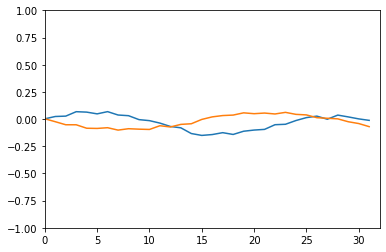

In [22]:
plt.plot(x_vals_control_off)
plt.plot(x_vals_control_on)
plt.axis([0, 32, -1, 1])

[0, 32, -1, 1]

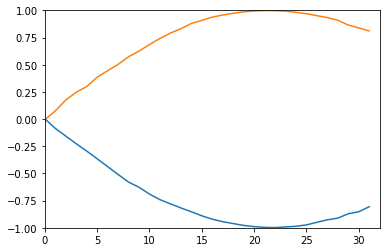

In [23]:
plt.plot(y_vals_control_off)
plt.plot(y_vals_control_on)
plt.axis([0, 32, -1, 1])

[0, 32, -1, 1]

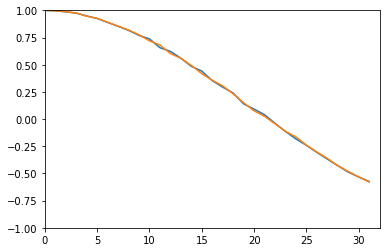

In [24]:
plt.plot(z_vals_control_off)
plt.plot(z_vals_control_on)
plt.axis([0, 32, -1, 1])